In [1]:
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = size / 200     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import time as time
from ast import literal_eval
FOLDER = 'resources/'

cost     = pd.read_csv(FOLDER + 'mandatory/route_weights.csv', encoding='utf-8-sig', sep=';')
stations = pd.read_csv(FOLDER + 'station.csv')
st_names = stations[['station', 'name', 'esr']].drop_duplicates().set_index('station')

cost.columns = ['link', 'long_link', 'cost', '1', '2']
cost = cost[['long_link', 'cost']]
cost['st_from_name'] = cost.long_link.apply(lambda x: [i.strip() for i in x.split(chr(8212))][0])
cost['st_to_name'] = cost.long_link.apply(lambda x: [i.strip() for i in x.split(chr(8212))][1])
cost['st_from_esr'] = cost.st_from_name.map(st_names.drop_duplicates('name').set_index('name').esr)
cost['st_to_esr'] = cost.st_to_name.map(st_names.drop_duplicates('name').set_index('name').esr)
cost['st_from'] = cost.st_from_name.map(stations.drop_duplicates('name').set_index('name').station)
cost['st_to'] = cost.st_to_name.map(stations.drop_duplicates('name').set_index('name').station)
print('Таблица с весами ребер графа сети загружена (первые 10 записей):')
print(cost.head(10).to_string(index=False))

Таблица с весами ребер графа сети загружена (первые 10 записей):
                long_link  cost st_from_name     st_to_name  st_from_esr  st_to_esr     st_from       st_to
          ХОНЫХ — КАМЫШТА     1        ХОНЫХ        КАМЫШТА        88766      88760  2000035542  2000035530
          КАМЫШТА — АСКИЗ     1      КАМЫШТА          АСКИЗ        88760      88700  2000035530  2000035496
     ХОНЫХ — ОРОСИТЕЛЬНЫЙ     1        ХОНЫХ   ОРОСИТЕЛЬНЫЙ        88766      88620  2000035542  2000035410
           ТЕЯ — БИСКАМЖА     1          ТЕЯ       БИСКАМЖА        88680      88660  2000035482  2000035466
              ТИСИН — СОН     1        ТИСИН            СОН        88562      88570  2000035374  2000035384
           СОН — ТУМАННЫЙ     1          СОН       ТУМАННЫЙ        88570      88571  2000035384  2000035386
     ТУМАННЫЙ — ЕРБИНСКАЯ     1     ТУМАННЫЙ      ЕРБИНСКАЯ        88571      88580  2000035386  2000035392
  НАХОДКА — ТИХООКЕАНСКАЯ     1      НАХОДКА  ТИХООКЕАНСКАЯ        9845

In [3]:
start_time = time.time()
# names
#all_stations = pd.Series(np.concatenate([cost.st_from_name.unique(), cost.st_to_name.unique()])).drop_duplicates().values
# id
all_stations = pd.Series(np.concatenate([cost.st_from_name.unique(), cost.st_to_name.unique()])).drop_duplicates().values
g = nx.DiGraph()
g.add_nodes_from(all_stations)
#g.add_weighted_edges_from(list(zip(cost.st_from_name, cost.st_to_name, cost.cost))) # names
g.add_weighted_edges_from(list(zip(cost.st_from_name, cost.st_to_name, cost.cost))) # id
print('NetworkX граф создан')

NetworkX граф создан


In [4]:
def get_path(df_cost, col_cost, suffix, st_from, st_to, details=False):
    if suffix == 'name':
        col_from, col_to = 'st_from_name', 'st_to_name'
    elif suffix == 'esr':
        col_from, col_to = 'st_from_esr', 'st_to_esr'
    else:
        col_from, col_to = 'st_from', 'st_to'
        
    gt = nx.DiGraph()
    all_stations = pd.Series(np.concatenate([df_cost[col_from].unique(), df_cost[col_to].unique()])).drop_duplicates().values
    gt.add_nodes_from(all_stations)
    gt.add_weighted_edges_from(list(zip(df_cost[col_from], df_cost[col_to], df_cost[col_cost])))

    print('Маршруты между станциями %s - %s:' % (st_from, st_to))
    path = nx.dijkstra_path(gt, st_from, st_to)
    length = nx.dijkstra_path_length(gt, st_from, st_to)
    print('\nМаршрут по алгоритму Дейкстры с учетом весов (суммарный вес %.1f): %s' % (length, path))
    if details:
        print(len(path))
        lpath = [(path[i-1], path[i]) for i in range(0, len(path))]
        show_cost = df_cost[df_cost.link_name.isin(lpath)].copy(deep=True)
        show_cost['ind'] = show_cost.st_from_name.apply(lambda x: path.index(x))
        print(show_cost.sort_values('ind')[['link_name', 'cost', col_cost]].to_string(index=False))
    print('\nКратчайший маршрут по количеству ребер (%d): %s' \
          % (nx.shortest_path_length(gt, st_from, st_to), nx.shortest_path(gt, st_from, st_to)))   
    
def get_path_no_print(df_cost, col_cost, suffix, st_from, st_to):
    if suffix == 'name':
        col_from, col_to = 'st_from_name', 'st_to_name'
    elif suffix == 'esr':
        col_from, col_to = 'st_from_esr', 'st_to_esr'
    else:
        col_from, col_to = 'st_from', 'st_to'
        
    gt = nx.DiGraph()
    all_stations = pd.Series(np.concatenate([df_cost[col_from].unique(), df_cost[col_to].unique()])).drop_duplicates().values
    gt.add_nodes_from(all_stations)
    gt.add_weighted_edges_from(list(zip(df_cost[col_from], df_cost[col_to], df_cost[col_cost])))

    path = nx.dijkstra_path(gt, st_from, st_to)
    length = nx.dijkstra_path_length(gt, st_from, st_to)
    return path, length

def get_all_paths(df_cost, col_cost, suffix):
    if suffix == 'name':
        col_from, col_to = 'st_from_name', 'st_to_name'
    elif suffix == 'esr':
        col_from, col_to = 'st_from_esr', 'st_to_esr'
    else:
        col_from, col_to = 'st_from', 'st_to'
        
    gt = nx.DiGraph()
    all_stations = pd.Series(np.concatenate([df_cost[col_from].unique(), df_cost[col_to].unique()])).drop_duplicates().values
    gt.add_nodes_from(all_stations)
    gt.add_weighted_edges_from(list(zip(df_cost[col_from], df_cost[col_to], df_cost[col_cost])))

    all_paths = nx.all_pairs_dijkstra_path(gt)
    all_lengths = nx.all_pairs_dijkstra_path_length(gt)
    return all_paths, all_lengths

st_from = 'МАРИИНСК'
st_to = 'АБАКАН'
all_paths = nx.all_pairs_dijkstra_path(g)
all_lengths = nx.all_pairs_dijkstra_path_length(g)
print('Выборка этого же маршрута из массива всех маршрутов:', all_paths[st_from][st_to])
print('\nTotal time = %.2f sec' % (time.time() - start_time))

Выборка этого же маршрута из массива всех маршрутов: ['МАРИИНСК', 'БОГОТОЛ', 'ЗЕРЦАЛЫ', 'АЧИНСК I', 'АЧИНСК II', 'ПРИГОРОДНЫЙ', 'УЛУЙ', 'НАЗАРОВО', 'КРАСНАЯ СОПКА', 'УЖУР', 'ТИСИН', 'СОН', 'ТУМАННЫЙ', 'ЕРБИНСКАЯ', 'ОРОСИТЕЛЬНЫЙ', 'ТИГЕЙ', 'ТАШЕБА', 'АБАКАН']

Total time = 3.00 sec


In [30]:
def save_paths_to_file(all_paths, all_lengths, filename='paths.csv'):
    print('Запись маршрутов в файл %s ...' % filename)
    start_time = time.time()
    a = pd.DataFrame(all_paths)
    b = pd.DataFrame(all_lengths)
    df_paths = a.unstack()
    df_paths.name = 'path'
    df_lengths = b.unstack()
    df_lengths.name = 'cost'
    df_paths = df_lengths.to_frame().join(df_paths).reset_index()
    df_paths.columns = ['ST_FROM', 'ST_TO', 'ROUTE_COST', 'ROUTE']
    df_paths.ST_FROM = df_paths.st_from.apply(int)
    df_paths.ST_TO = df_paths.st_to.apply(int)
    df_paths.ROUTE_COST = df_paths.ROUTE_COST.apply(lambda x: np.round(x, 2))
    df_paths.ROUTE = df_paths.ROUTE.apply(lambda x: str(x)[1:-1].replace(', ', ','))
    df_paths.to_csv(filename, encoding='utf-8-sig', index=False, sep=';')
    print('Маршруты выгружены в файл %s' % filename)
    print('Total time = %.2f sec' % (time.time() - start_time))
    print('Примеры маршрутов:')
    print(df_paths.sample(10).to_string(index=False))

In [7]:
tepl_coef = 0.2
one_line_coef = 0.4

# Функция возвращает 1, если участок принадлежит электровозному тяговому плечу, и 1+set_coeff, если тепловозному
def set_cost(regs, set_coeff=tepl_coef):
    if len(regs) > 0:
        if 'Электровоз' in reg_type[reg_type.loco_region.isin(regs)].reg_type.to_string():
            cost = 1
        else:
            cost = 1 + set_coeff
    else:
        cost = 1 + set_coeff
    return cost

reg_type = pd.read_csv(FOLDER + 'mandatory/reg_type.csv', encoding='utf-8-sig', sep=';')
reg_type.columns = ['loco_region', 'reg_name', 'reg_type']
links = pd.read_csv(FOLDER + 'link.csv', encoding='utf-8-sig')
stations_regs = stations.groupby('station').loco_region.apply(lambda x: x.values)
stations['reg_type'] = stations.loco_region.map(reg_type.set_index('loco_region').reg_type)
links['regs'] = links.st_from.map(stations_regs.to_frame().loco_region)\
                .combine(links.st_to.map(stations_regs.to_frame().loco_region), np.intersect1d)
links['tcost'] = links.regs.apply(lambda x: set_cost(x))
cost['link'] = list(zip(cost.st_from, cost.st_to))
cost['link_name'] = list(zip(cost.st_from_name, cost.st_to_name))
links['link'] = list(zip(links.st_from, links.st_to))
links['tcost'] = links.tcost - (links.lines - 2) * one_line_coef
print(links.head(10).to_string(index=False))

                     link     st_from       st_to   time  dist  dir  lines  road                      regs  tcost
 (2000038914, 2000038918)  2000038914  2000038918   2700    18    0      1    96              [2002119312]    1.4
 (2000037826, 2000037816)  2000037826  2000037816  16080    83    1      1    94              [2002119288]    1.6
 (2000037840, 2000037846)  2000037840  2000037846   2820    43    0      1    94              [2002119288]    1.6
 (2000035344, 2000035374)  2000035344  2000035374  10500   134    1      1    88              [2002119284]    1.6
 (2000035112, 2000035194)  2000035112  2000035194   1380    20    0      1    88              [2002119286]    1.6
 (2000035410, 2000035544)  2000035410  2000035544    360     6    1      1    88  [2002119284, 2002119301]    1.4
 (2000035860, 2000035880)  2000035860  2000035880   3180    30    1      1    88  [2002119299, 2002119322]    1.4
 (2000035386, 2000035392)  2000035386  2000035392    780    15    1      1    88        

In [14]:
COST_FOR_ABSENT_LINK = 5.0
def get_cost_for_absent_link(ser, fill_type='mean'):        
    return ser.mean() if fill_type == 'mean' else COST_FOR_ABSENT_LINK

cost['tcost'] = cost.link.map(links.set_index('link').tcost)
cols = ['link_name', 'cost', 'tcost']
cost['tcost'] = cost.tcost + (cost.cost - 1)
cost['tcost'] = cost.tcost.apply(lambda x: 0 if x < 0 else x)
print('Участки, для которых не заданы веса:', cost[cost.tcost.isnull()].link_name.unique())
cost['tcost'].fillna(np.round(get_cost_for_absent_link(cost.tcost, fill_type='const'), 2), inplace=True)
#print(cost.sort_values('tcost', ascending=True).head(10)[cols].to_string(index=False))
links['st_from_name'] = links.st_from.map(st_names.name)
links['st_to_name'] = links.st_to.map(st_names.name)
links_cols = ['st_from_name', 'st_to_name', 'time', 'dist', 'dir', 'lines', 'road', 'tcost']

Участки, для которых не заданы веса: [('МАХАЛИНО', 'КАМЫШОВАЯ') ('БИРА', 'БИРОБИДЖАН I')
 ('БИРОБИДЖАН I', 'ВОЛОЧАЕВКА I') ('БИРОБИДЖАН I', 'БИРОБИДЖАН II')
 ('БИРОБИДЖАН II', 'БИРОФЕЛЬД') ('КАМЫШОВАЯ', 'МАХАЛИНО')
 ('БИРОБИДЖАН I', 'БИРА') ('ВОЛОЧАЕВКА I', 'БИРОБИДЖАН I')
 ('БИРОБИДЖАН II', 'БИРОБИДЖАН I') ('БИРОФЕЛЬД', 'БИРОБИДЖАН II')]


In [15]:
get_path(cost, 'tcost', suffix='name', st_from='МАРИИНСК', st_to='ПОСТЫШЕВО', details=True)

Маршруты между станциями МАРИИНСК - ПОСТЫШЕВО:

Маршрут по алгоритму Дейкстры с учетом весов (суммарный вес 115.6): ['МАРИИНСК', 'БОГОТОЛ', 'ЗЕРЦАЛЫ', 'АЧИНСК I', 'ЧЕРНОРЕЧЕНСКАЯ', 'БУГАЧ', 'КРАСНОЯРСК-СЕВЕРНЫЙ', 'КРАСНОЯРСК-ВОСТОЧНЫЙ', 'ЗЫКОВО', 'УЯР', 'ЗАОЗЕРНАЯ', 'ИЛАНСКАЯ', 'РЕШОТЫ', 'КЛЮЧИ', 'ЮРТЫ', 'ТАЙШЕТ', 'ТОРЕЯ', 'ТУРМА', 'ВИХОРЕВКА', 'МОРГУДОН', 'ГАЛАЧИНСКИЙ', 'ПАДУНСКИЕ ПОРОГИ', 'ГИДРОСТРОИТЕЛЬ', 'КОРШУНИХА-АНГАРСКАЯ', 'ХРЕБТОВАЯ', 'ЛЕНА', 'ЯКУРИМ', 'ЛЕНА-ВОСТОЧНАЯ', 'ЧУДНИЧНЫЙ', 'ЗВЕЗДНАЯ', 'НИЯ', 'ТАКОВКА', 'НЕБЕЛЬ', 'КИРЕНГА', 'КУНЕРМА', 'ДАБАН', 'ТЫЯ', 'СЕВЕРОБАЙКАЛЬСК', 'НОВЫЙ УОЯН', 'АНГАРАКАН', 'КАЗАНКАН', 'ТАКСИМО', 'КУАНДА', 'БАЛБУХТА', 'СЮЛЬБАН', 'НОВАЯ ЧАРА', 'ИКАБЬЯКАН', 'ХАНИ', 'ОЛЕКМА', 'ЮКТАЛИ', 'ЛОПЧА', 'КУВЫКТА', 'ТЫНДА', 'ШАХТАУМ', 'БЕСТУЖЕВО', 'ДИПКУН', 'ВЕРХНЕЗЕЙСК', 'ФЕВРАЛЬСК', 'НОВЫЙ УРГАЛ', 'УРГАЛ I', 'СОЛОНИ', 'ДУССЕ-АЛИНЬ', 'СУЛУК', 'ПОСТЫШЕВО']
64
                                   link_name  cost  tcost
                         (МАРИИНСК, БОГОТОЛ

In [32]:
start_time = time.time()
links['el'] = links.regs.apply(lambda x: set_cost(x, set_coeff=-1)) # el = 1, если участок электровозный и 0, если тепловозный

res = []
tests = [['МАРИИНСК', 'НАХОДКА', 'ИРКУТСК-СОРТИРОВОЧНЫЙ', True],
        ['МАРИИНСК', 'ВАНИНО', 'ИРКУТСК-СОРТИРОВОЧНЫЙ', True],
        ['БЕРКАКИТ', 'ХАБАРОВСК II', 'СКОВОРОДИНО', True],
        ['ВАНИНО', 'ТАКСИМО', 'СОЛОНИ', True],
        ['АЧИНСК I', 'АБАКАН', 'УЖУР', True],
        ['ЗИМА', 'СЛЮДЯНКА I', 'КАЯ', False],
        ['АЧИНСК I', 'ИЛАНСКАЯ', 'КРАСНОЯРСК-ВОСТОЧНЫЙ', True],
        ['МАРИИНСК', 'ТЫНДА', 'ИРКУТСК-СОРТИРОВОЧНЫЙ', True]]
        #['МАРИИНСК', 'ПОСТЫШЕВО', 'ИРКУТСК-СОРТИРОВОЧНЫЙ', True]]        

STEP = 0.05
bound = int(1 / STEP)
iterations = (bound + 1) * (bound + 1)

iters = []
for i in np.linspace(0, 1, bound + 1):
    for j in np.linspace(0, 1, bound + 1):
        iters.append([i, j])
        
for [tepl_coef, one_line_coef] in log_progress(iters, every = bound + 1, size=iterations):    
    links['tcost'] = 1 + (1 - links.el) * tepl_coef - (links.lines - 2) * one_line_coef
    cost['tcost'] = cost.link.map(links.set_index('link').tcost) + (cost.cost - 1)
    cost['tcost'] = cost.tcost.apply(lambda x: 0 if x < 0 else x)
    cost['tcost'].fillna(np.round(get_cost_for_absent_link(cost.tcost, fill_type='const'), 2), inplace=True)
    if cost[cost.tcost<0].empty:
        result = []
        for test in tests:
            path1, length1 = get_path_no_print(cost, 'tcost', suffix='name', st_from=test[0], st_to=test[1])
            path2, length2 = get_path_no_print(cost, 'tcost', suffix='name', st_from=test[1], st_to=test[0])
            result.append((test[2] in path1) == test[3])
            result.append((test[2] in path2) == test[3])

        total = np.array(result).sum()            
        if total == 2 * len(tests):
            print('SUCCESS: tepl = %.2f, one_line = %.2f' % (tepl_coef, one_line_coef))
        res.append([tepl_coef, one_line_coef, int(total)])
            
print('Finish. Total time = %.2f sec' % (time.time() - start_time))
df_res = pd.DataFrame(res, columns=['tepl', 'one_line', 'test'])

SUCCESS: tepl = 0.40, one_line = 0.75
SUCCESS: tepl = 0.45, one_line = 0.75
SUCCESS: tepl = 0.50, one_line = 0.75
SUCCESS: tepl = 0.55, one_line = 0.70
SUCCESS: tepl = 0.55, one_line = 0.75
SUCCESS: tepl = 0.60, one_line = 0.70
SUCCESS: tepl = 0.60, one_line = 0.75
SUCCESS: tepl = 0.65, one_line = 0.70
SUCCESS: tepl = 0.65, one_line = 0.75
SUCCESS: tepl = 0.70, one_line = 0.65
SUCCESS: tepl = 0.70, one_line = 0.70
SUCCESS: tepl = 0.70, one_line = 0.75
SUCCESS: tepl = 0.75, one_line = 0.65
SUCCESS: tepl = 0.75, one_line = 0.70
SUCCESS: tepl = 0.75, one_line = 0.75
SUCCESS: tepl = 0.80, one_line = 0.65
SUCCESS: tepl = 0.80, one_line = 0.70
SUCCESS: tepl = 0.80, one_line = 0.75
SUCCESS: tepl = 0.85, one_line = 0.60
SUCCESS: tepl = 0.85, one_line = 0.65
Finish. Total time = 53.02 sec


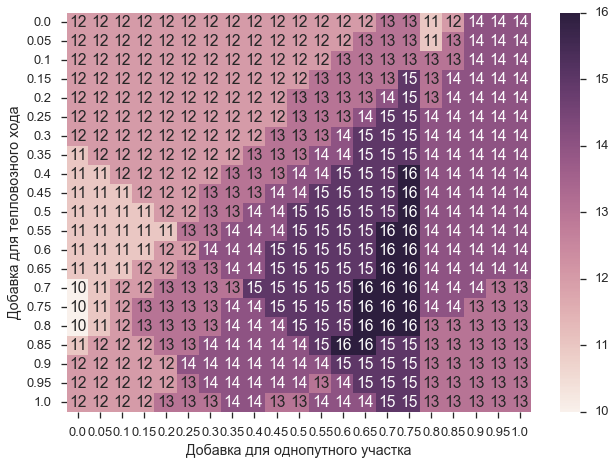

In [33]:
import seaborn as sns
%matplotlib inline
df_piv = df_res.pivot('tepl', 'one_line', 'test')
sns.set_style('ticks')
sns.set_context('talk')
ax = sns.heatmap(df_piv, annot=True, fmt='d', linewidths=.0)
ax.set_xlabel('Добавка для однопутного участка')
ax.set_ylabel('Добавка для тепловозного хода')

## Вывод наилучших весов и маршрутов

## Результаты тестов

### Запись наилучших весов в датафрейм

In [18]:
tepl_coef = 0.75
one_line_coef = 0.7
links['el'] = links.regs.apply(lambda x: set_cost(x, set_coeff=-1)) # el = 1, если участок электровозный и 0, если тепловозный
links['tcost'] = 1 + (1 - links.el) * tepl_coef - (links.lines - 2) * one_line_coef
cost['tcost'] = cost.link.map(links.set_index('link').tcost) + (cost.cost - 1)
cost['tcost'] = cost.tcost.apply(lambda x: 0 if x < 0 else x)
cost['tcost'].fillna(np.round(get_cost_for_absent_link(cost.tcost, fill_type='const'), 2), inplace=True)
cost['tcost_round'] = cost.tcost.apply(lambda x: '{:.2f}'.format(x))

### Результаты тестов

In [19]:
for test in tests:    
    path1, length1 = get_path_no_print(cost, 'tcost', suffix='name', st_from=test[0], st_to=test[1])
    #path2, length2 = get_path_no_print(cost, 'tcost', suffix='name', st_from=test[1], st_to=test[0])
    res = (test[2] in path1) == test[3]    
    print('%s. Path from %s to %s (total cost %.2f): %s\n' % (str(res).upper(), test[0], test[1], length1, path1))    

TRUE. Path from МАРИИНСК to НАХОДКА (total cost 139.90): ['МАРИИНСК', 'БОГОТОЛ', 'ЗЕРЦАЛЫ', 'АЧИНСК I', 'ЧЕРНОРЕЧЕНСКАЯ', 'БУГАЧ', 'КРАСНОЯРСК-СЕВЕРНЫЙ', 'КРАСНОЯРСК-ВОСТОЧНЫЙ', 'ЗЫКОВО', 'УЯР', 'ЗАОЗЕРНАЯ', 'ИЛАНСКАЯ', 'РЕШОТЫ', 'КЛЮЧИ', 'ЮРТЫ', 'ТАЙШЕТ', 'БАЙРОНОВКА', 'АЛЗАМАЙ', 'НИЖНЕУДИНСК', 'УДА II', 'ТУЛУН', 'АЗЕЙ', 'КУЙТУН', 'ПЕРЕВОЗ', 'ЗИМА', 'ЗАЛАРИ', 'ЧЕРЕМХОВО', 'КАСЬЯНОВКА', 'МАЛЬТА', 'КИТОЙ', 'АНГАРСК', 'СУХОВСКАЯ', 'МЕГЕТ', 'БАТАРЕЙНАЯ', 'ИРКУТСК-СОРТИРОВОЧНЫЙ', 'ГОНЧАРОВО', 'БОЛЬШОЙ ЛУГ', 'АНДРИАНОВСКАЯ', 'АНГАСОЛКА', 'СЛЮДЯНКА II', 'СЛЮДЯНКА I', 'БАЙКАЛЬСК', 'МЫСОВАЯ', 'УЛАН-УДЭ', 'ЗАУДИНСКИЙ', 'ТАЛЬЦЫ', 'ЧЕЛУТАЙ', 'ГОРХОН', 'КИЖА', 'ПЕТРОВСКИЙ ЗАВОД', 'ЖИПХЕГЕН', 'ХИЛОК', 'МОГЗОН', 'ТУРГУТУЙ', 'ЛЕСНАЯ', 'КАДАЛА', 'ЧИТА I', 'КАРЫМСКАЯ', 'ТАРСКАЯ', 'УРУЛЬГА', 'СОЛНЦЕВАЯ', 'ШИЛКА-ТОВАРНАЯ', 'ШИЛКА-ПАССАЖИРСКАЯ', 'ПРИИСКОВАЯ', 'КУЭНГА', 'ЧЕРНЫШЕВСК-ЗАБАЙКАЛЬСКИЙ', 'ЖИРЕКЕН', 'ЗИЛОВО', 'КСЕНЬЕВСКАЯ', 'МОГОЧА', 'АМАЗАР', 'ЕРОФЕЙ ПАВЛОВИЧ', 'УРУША', 'БАМОВСКАЯ', 'ГОРЕЛЫЙ', 'С

In [20]:
path1, length1 = get_path_no_print(cost, 'tcost', suffix='name', st_from='МАРИИНСК', st_to='МЕЖДУРЕЧЕНСК')
print(path1)

['МАРИИНСК', 'БОГОТОЛ', 'ЗЕРЦАЛЫ', 'АЧИНСК I', 'АЧИНСК II', 'ПРИГОРОДНЫЙ', 'УЛУЙ', 'НАЗАРОВО', 'КРАСНАЯ СОПКА', 'УЖУР', 'ТИСИН', 'СОН', 'ТУМАННЫЙ', 'ЕРБИНСКАЯ', 'ОРОСИТЕЛЬНЫЙ', 'ХОНЫХ', 'КАМЫШТА', 'АСКИЗ', 'ХАБЗАС', 'НАНХЧУЛ', 'БИСКАМЖА', 'МЕЖДУРЕЧЕНСК']


### Выгрузка весов в файл

In [26]:
df_cost = cost[['st_from', 'st_to', 'st_from_esr', 'st_to_esr', 'st_from_name', 'st_to_name', 'tcost_round']]
df_cost.columns = df_cost.columns.map(lambda x: x.upper())
filename = FOLDER + 'cost.csv'
df_cost.to_csv(filename, encoding='utf-8-sig', index=False, sep=';')
print('Веса участков выгружены в файл', filename)

Веса участков выгружены в файл resources/cost.csv


### Выгрузка маршрутов в файл

In [31]:
all_paths, all_lengths = get_all_paths(cost, 'tcost', suffix='')
save_paths_to_file(all_paths, all_lengths, filename='paths_id.csv')

Запись маршрутов в файл paths_id.csv ...


AttributeError: 'DataFrame' object has no attribute 'st_from'